In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os

file_path = "../data/incendies/incendies_V2.csv"

# Charger le fichier téléchargé sur data.gouv.fr
df_incendie = pd.read_csv(file_path)

C:\Users\simon\AppData\Local\Temp\ipykernel_19104\2289822461.py:9: DtypeWarning: Columns (16,19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_incendie = pd.read_csv(file_path)


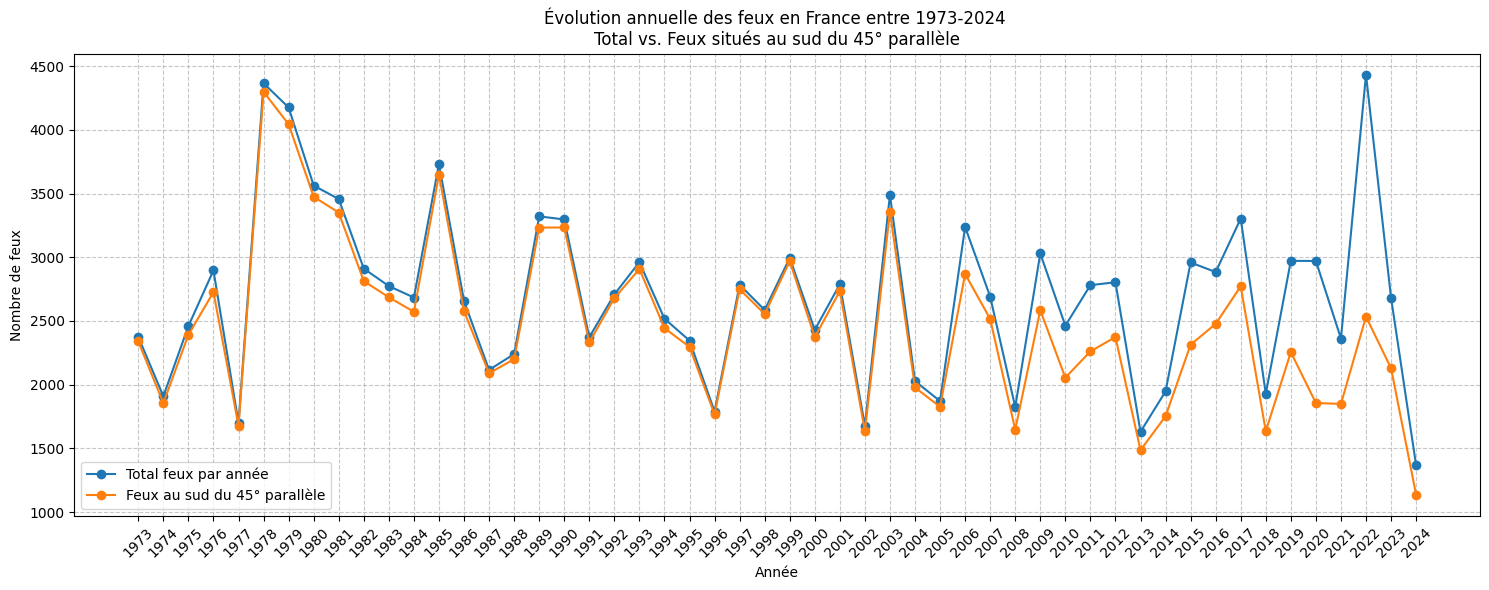

In [30]:
# Copier le dataset
df = df_incendie.copy()

# S'assurer que la latitude est numérique
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")

# Compter le nombre de feux par année
fires_per_year = df.groupby("Année").size()

# Compter les feux au sud du 45e parallèle
fires_south = df[df["latitude"] < 45].groupby("Année").size()

# Créer le graphique
plt.figure(figsize=(15,6))

plt.plot(fires_per_year.index, fires_per_year.values, label="Total feux par année", marker='o')
plt.plot(fires_south.index, fires_south.values, label="Feux au sud du 45° parallèle", marker='o')

# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.7)

# Ajouter labels et titre
plt.xlabel("Année")
plt.ylabel("Nombre de feux")
plt.title("Évolution annuelle des feux en France entre 1973-2024 \nTotal vs. Feux situés au sud du 45° parallèle")

# Afficher toutes les années sur l'axe des x
plt.xticks(fires_per_year.index, rotation=45)

plt.legend()
plt.tight_layout()
# Sauvegarde
plt.savefig("../image/serie_temp_feux.png", dpi=300)
plt.show()

In [31]:
df = pd.read_parquet("../data/rawtimeseries.parquet")


In [32]:
# Réinitialiser l'index pour avoir y, x, time comme colonnes
df_reset = df.reset_index()

# Assurez-vous que la colonne 'time' est au format datetime
df_reset['time'] = pd.to_datetime(df_reset['time'])

# Extraire l'année
df_reset['year'] = df_reset['time'].dt.year
df_reset['tasAdjust_celsius'] = df_reset['tasAdjust'] - 273.15
# Si vos données sont journalières → 86400 secondes par jour
seconds_per_timestep = 86400

# Convertir prAdjust (kg/m2/s) -> mm par pas de temps
df_reset['pr_mm'] = df_reset['prAdjust'] * seconds_per_timestep

# Agrégation annuelle
df_yearly = df_reset.groupby('year').agg({
    'tasAdjust_celsius': 'mean',
    'pr_mm': 'sum',       # précipitations annuelles en mm
    'fire': 'sum'
}).reset_index()


print(df_yearly)



    year  tasAdjust_celsius      pr_mm    fire
0   2004          12.774787  8122447.5  1856.0
1   2005          11.283225  9363820.0  1715.0
2   2006          11.941114  7446241.0  2934.0
3   2007          11.438198  7692301.5  2458.0
4   2008          11.917321  8836699.0  1686.0
5   2009          12.108392  8042924.0  2742.0
6   2010          12.029229  8796044.0  2241.0
7   2011          10.584099  8572798.0  2535.0
8   2012          10.746801  9948925.0  2569.0
9   2013          11.747005  8165111.5  1367.0
10  2014          11.042568  7986527.0  1599.0


C:\Users\simon\AppData\Local\Temp\ipykernel_19104\296140830.py:37: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(lines1 + lines2 + labels2 + lines3,


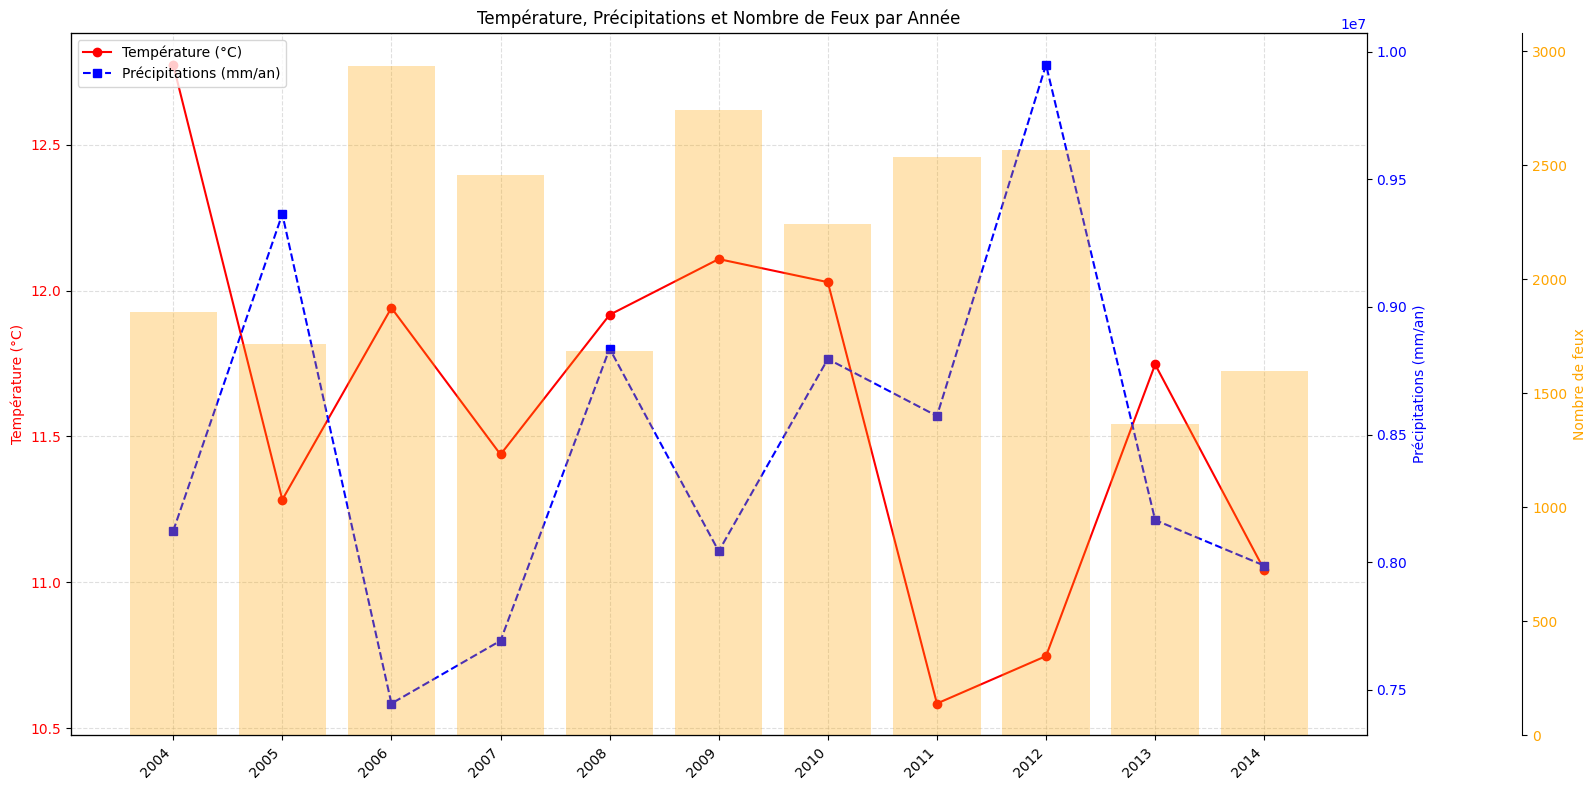

In [33]:
# ------------------- GRAPHIQUE -------------------
fig, ax1 = plt.subplots(figsize=(16, 8))

# 1. Température
ax1.plot(df_yearly['year'], df_yearly['tasAdjust_celsius'],
         marker='o', color='red', label="Température (°C)")
ax1.set_ylabel("Température (°C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 2. Précipitations (premier axe droit)
ax2 = ax1.twinx()
ax2.plot(df_yearly['year'], df_yearly['pr_mm'],
         marker='s', linestyle='--', color='blue', label="Précipitations (mm/an)")
ax2.set_ylabel("Précipitations (mm/an)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 3. Nombre de feux (barres, deuxième axe droit)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.12))
ax3.bar(df_yearly['year'], df_yearly['fire'],
        alpha=0.3, color='orange', label="Nombre de feux")
ax3.set_ylabel("Nombre de feux", color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# ------------------- AXE X : Afficher CHAQUE année -------------------
ax1.set_xticks(df_yearly['year'])
ax1.set_xticklabels(df_yearly['year'], rotation=45, ha='right')

# ------------------- Grille complète -------------------
ax1.grid(which='both', axis='both', linestyle='--', alpha=0.4)

# ------------------- Légende -------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

plt.legend(lines1 + lines2 + labels2 + lines3,
           labels1 + labels2 + labels3,
           loc="upper left")

plt.title("Température, Précipitations et Nombre de Feux par Année")
plt.tight_layout()

# Sauvegarde
plt.savefig("../image/serie_temp_precip_feux_3_axes.png", dpi=300)

plt.show()
